### Calculate life cycle emission and sequestration of burial of biochar
Contributor to code and data <br>
Soomin Chun, NREL (Schun@nrel.gov): general coding <br>
Rebecca Hanes, NREL (Rhanes@nrel.gov): collection of biomass (roadside) and transportation of biomass <br>
Brian Gentry, NREL (Bgentry@nrel.gov): calculation of county-level counterfactual of forest biomass for United States with expansion of C-Brec model

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Load input data
df = pd.read_csv('../data/user_input/variables_091225.csv') # Change file path properly. Can change scenario name and variables in csv
inputs = df.copy()
inputs.head()

,scenario,fips_feedstock,C_biomass,C_biochar,effluent_vapor_LHV,MC_biomass,MC_literature,bulk_density_literature,feedstock_transport_truck_distance,power_requirements,...,Eefficiency_conversion,mile_transport_bioproduct,diesel_burial,counterfactual_preburn,counterfactual_piledratio,SOC_0,density_soil,C_oxidation_percent,density_char,HCorg
0,min_storage,8051,0.41,0.50,11,0.20,0.40,0.3011,100,64,...,0.63,60,0.5,R4,70,31.0,1.7,10,0.17,0.5
1,max_storage,8051,0.50,0.85,20,0.03,0.35,0.3668,10,16,...,1.00,0,0.0,R1,70,1.5,1.0,0,0.70,0.0


In [3]:
# Or enter input data directly

manual_entry = False

if manual_entry:
    inputs = {'scenario':['case1'],
            'fips_feedstock':[8051], # fips code of county where forest feedstock collected
            'C_biomass':[0.41], # Carbon content of biomass, weight fraction, dry basis
            'C_biochar':[0.50], # Carbon content of biochar, weight fraction, dry basis
            'effluent_vapor_LHV': [11], # Lower heating value of effluent vapor, GJ/tonne vapor
            'MC_biomass': [0.03], # Moisture content of biomass, weight fraction, wet basis
            'MC_literature': [0.35], # Moisture content of forest residue from literature source, only used for correction of buil density of biomass, weithg ratio, dry basis
            'bulk_density_literature': [0.3668], # Bulk density of wet chipped residues from literature source, only used for corection of bulk density of biomass, Wet metric tonnes chipped residue/m3
            'feedstock_transport_truck_distance': [10], # Transportation distance from forest biomass source to reactor, km
            'power_requirements': [16], # Electrical power to operate motors and support electrical control and monitoring equipment, kWh/tonne biomass
            'temp_process': [275], # Temperature for conversion, degree Celsius
            'yield_biochar': [0.2], # Weight of char produced per weight of biomass, weight fraction
            'Eefficiency_conversion': [0.63], # Energy efficiency of the reactor, ratio
            'mile_transport_bioproduct': [0], # Tranportation distance from reactor to burial site
            'diesel_burial': [0], # Volume of diesel used for burial of biomass, gal/tonne biomass
            'counterfactual_preburn': ['R4'], # Counterfactual scenario 
            # R1: biomass left on site / R2: Pile burn / R3: Broadcast burn / R4: Pile and broadcast burn
            'counterfactual_piledratio': [70], # piled to scatter ratio (Available values: 0/30/50/70)
            'SOC_0': [1.5], # Mass of carbon in the initial soil of burial site, g/kg
            'density_soil': [1], # Density of soil of burial site, metric tons/cubic meter
            'C_oxidation_percent': [0], # Oxidation ratio of carbon over 100 years, %
            'density_char': [0.17], # Density of biochar, tonne/cubic meter
            'HCorg': [0], # Hydrogen to organic carbon ratio
            }
    inputs = pd.DataFrame(data=inputs)
    df = inputs.copy()

In [4]:
df.columns 

Index(['scenario', 'fips_feedstock', 'C_biomass', 'C_biochar',
       'effluent_vapor_LHV', 'MC_biomass', 'MC_literature',
       'bulk_density_literature', 'feedstock_transport_truck_distance',
       'power_requirements', 'temp_process', 'yield_biochar',
       'Eefficiency_conversion', 'mile_transport_bioproduct', 'diesel_burial',
       'counterfactual_preburn', 'counterfactual_piledratio', 'SOC_0',
       'density_soil', 'C_oxidation_percent', 'density_char', 'HCorg'],
      dtype='object')

In [5]:
### Calculate emission during conversion process

# constants
reactor_C_loss = 0.01 # fraction of carbon loss during conversion
LHV_propane = 46.4 # lower heating  value of propane, MJ/kg
Cp_biomass = 2 # Specific heat of dry biomass, kJ/kg degreeC
heat_vap_water = 2260 # latent vaporization heat of water, kJ/kg
Cp_water_l = 4.2 # Specific heat of liquid water, kJ/kg degreeC
Cp_water_v = 2 # Specific heat of vapor water, kJ/kg degreeC
MW_C = 12 # u
MW_CO2 = 44 # u
kg_per_t = 1000
kilo_per_giga = 1000000
dry_matter_loss_transport = 0.02
co2e_elec_upst = 0.000432 #tCO2e/kWh

# Changed equation to be based on dry biomass. So every calculated values are based on ton of dry biomass
df['Mass_biochar'] = df['yield_biochar'] # mass of biochar produced from 1 ton of dry biomass, ton
df['MassC_biochar'] = df['Mass_biochar']*df['C_biochar'] # mass of carbon in produced biochar, ton
df['MassC_vapor'] = df['C_biomass']*(1-reactor_C_loss)-df['MassC_biochar'] # mass of carbon in vapor considering carbon loss from reactor, ton
df['MassC_loss'] = df['C_biomass']*reactor_C_loss # mass of carbon loss to atmosphere as vapor, ton

# Check mass conservation
df['MassC_balance']=df['MassC_biochar']+df['MassC_vapor']+df['MassC_loss']-df['C_biomass'] # should be close to zero

# Calculate energy
df['E_vapor'] = (1-reactor_C_loss-df['yield_biochar'])*df['effluent_vapor_LHV']*kilo_per_giga # energy produced from combustion of effluent vapor, KJ
df['E_biomass'] = Cp_biomass * (df['temp_process']-25) * kg_per_t # energy required to heat biomass to processing temperature, KJ
df['E_water'] = df['MC_biomass']/(1-df['MC_biomass']) * (heat_vap_water + (100-25)*Cp_water_l + (df['temp_process']-100)*Cp_water_v) * kg_per_t 
# energy required to heat and vaporize water from 25 to processing temperature, KJ

# propane_required [kg/tonne biomass], propane required for additional energy
df['propane_required'] = ((df['E_biomass'] + df['E_water'])/df['Eefficiency_conversion'] - df['E_vapor']) * 0.001/LHV_propane
# Combust propane additionally only when energy required to heat biomass and water is greater than energy produced from combustion of effluent vapor
mask = df['propane_required'] < 0
df.loc[mask, 'propane_required'] = 0  # Set negative values to zero

### Calculate amount stored carbon as CO2 in char
# Carbon stored as CO2
df['co2e_stored_t_tonnebiomass'] = df['MassC_biochar'] / MW_C * MW_CO2

### Calculate emissions
# co2e_vapor [tCO2e/tonne biomass], CO2 emissions from combusting vapor effluent
df['reactor_onsite_vapor_tCO2e_tonnebiomass'] = df['MassC_vapor'] / MW_C * MW_CO2

# CO2e_loss [tCO2e/tonne biomass], CO2 emissions from loss to atmosphere as vapor
df['reactor_onsite_loss_tCO2e_tonnebiomass'] = df['MassC_loss'] / MW_C * MW_CO2

# co2e_propane [t], CO2 emission from combustion of propane
df['reactor_propane_tCO2e_tonnebiomass'] = df['propane_required'] * 3.9662310809926598 / kg_per_t

# Calculate wet tonne of raw biomass for 1 tonne of dry biomass
df['wet_t_rawbiomss_tonnebiomass'] = 1/(1-df['MC_biomass'])

# upstream emission of electricity for conversion
df['elec_tCO2e_tonnebiomass'] = co2e_elec_upst*df['wet_t_rawbiomss_tonnebiomass']*df['power_requirements'] #tCO2e/tonne-biomass

In [6]:
### Calculate embodied emission of reactor construction
# sensitivity inputs - foreground LCI
height = 35.544 # ft, height of reactor
diameter = 12.0081 # ft, diameter of reactor
unit_no = 4 # units, number of units for reactor
thick_carbon_steel = 15 # mm, thickness of carbon steel
thick_refractory_material = 100 # mm, thickness of silica
energy = 0 # update later
capacity = 5000 # tons biomass/day-unit
lifetime = 30 # year
# sensitivity inputs - background LCI
co2e_carbon_steel = 1.56 # kgCO2e/kg, USLCI, Steel; hot rolled coil, at plant_kilogram
co2_refractory_material = 19276 # g/ton Greet2 (Isaias)
ch4_refractory_material = 40.528 # g/ton Greet2
n2o_refractory_material = 0.385 # g/ton # take care when do sensitivity analysis, as material used as refractory material can be more complex than just silica

# These are the mean AR6 factors to convert kg GHG to kg CO2eq
gwp_ch4 = 29.8
gwp_ch4_bio = 27.0
gwp_n2o = 276.0  

### Calculate intermediate variables
kg_per_ton = 1000
g_per_kg = 1000
ft_per_m = 3.281
mm_per_m = 1000
density_carbon_steel = 2403 #kg/m3 for steel, chips, engineeringtoolbox
density_refractory_material = 1522 #kg/m3 for silica sand, engineeringtoolbox

# vol_carbon_steel, m3
vol_carbon_steel = np.pi*((diameter/ft_per_m/2)**2-(diameter/ft_per_m/2-thick_carbon_steel/mm_per_m)**2)*(height/ft_per_m)

# vol_refractory_material, m3
vol_refractory_material = np.pi*((diameter/ft_per_m/2-thick_carbon_steel/mm_per_m)**2-(diameter/ft_per_m/2-(thick_carbon_steel+thick_refractory_material)/mm_per_m)**2)*(height/ft_per_m)

# embodied_emission_carbon_steel,tCO2 for all materials used for construction of reactors
co2e_material = vol_carbon_steel*density_carbon_steel*(co2e_carbon_steel/kg_per_ton) \
            + vol_refractory_material*density_refractory_material*(co2_refractory_material/kg_per_ton/g_per_kg/kg_per_ton) \
            + vol_refractory_material*density_refractory_material*(ch4_refractory_material/kg_per_ton/g_per_kg/kg_per_ton)*gwp_ch4 \
            + vol_refractory_material*density_refractory_material*(n2o_refractory_material/kg_per_ton/g_per_kg/kg_per_ton)*gwp_n2o

co2e_reactor = co2e_material

# calculate how much biomass can be treated for lifetime of reactor
# tons biomass per lifetime
year_to_day = 365
capacity_lifetime = capacity*unit_no*lifetime*year_to_day

# calculate co2e_reactor per ton of biomass treated
co2e_reactor_ton_tonbiomass = co2e_reactor/capacity_lifetime
# calculate emission for biomass treated
df['reactor_tCO2e_tonnebiomass'] = 1/(1-df['MC_biomass'])*co2e_reactor_ton_tonbiomass

In [7]:
### Calculate emission for biochar burial
kg_per_t = 1000
g_per_kg = 1000
diesel_upst = 19.46 # gCO2eq/MJ

df['injection_diesel_tCO2e_tonnebiomass'] = df['diesel_burial']*12.659785825341698/kg_per_t

In [8]:
### Calculate emission for transporatation of biochar
mile_per_gallon_diesel = 9
bulk_capacity_ton_truck = 17 # tonnes/truck
kg_per_t = 1000

df['transport_bioproduct_diesel_tCO2e_tonnebiomass'] = (df['mile_transport_bioproduct'] / mile_per_gallon_diesel / bulk_capacity_ton_truck) * 12.659785825341698/kg_per_t

In [9]:
### Calculate soil emission
# soil emission
kg_per_tonne = 1000
g_per_kg = 1000

df['vol_char'] = 1/df['density_char'] # cubic meter, convert 1 dry tonne of biochar to volume in cubic meter
df['mass_SOC_0'] = df['density_soil']*df['vol_char']*df['SOC_0']/g_per_kg # metric tons, Mass of carbon in initial soil

df['soil_emission_longterm_tCO2_tonnebiomass'] = df['Mass_biochar']*df['mass_SOC_0']*df['C_oxidation_percent']*0.01 # metric tons CO2

# durability
df['char_emission_longterm_tCO2_tonnebiomass'] = df['co2e_stored_t_tonnebiomass']*(1.04-0.635)*df['HCorg']

In [10]:
### Calculate emission during collection of forest biomass
fips_feedstock = 8051 # Gunnison County, CO (selected county of Colorado where the feedstock availability are the greatest
MC_biomass = 3 # Moisture content of forest residue at reactor, wet basis weight percent
MC_literature = 0.35 # Moisture content of forest redisue from literature source, dry basis wet ratio
bulk_density_literature = 0.3668 # bulk density of wet chipped residues from literature source, wet metric tonnes chipped residue/m3
data_dir = Path("../data/formatted_data")

### Calculate amount of residue (dry tonne) required to be removed from forest
# Set size reduction loss to zero unless the feedstock is being pelletized
dry_matter_loss_sizereduction = 0.0 #if feedstock_format == 'chips' else dry_matter_loss_sizereduction
df['feed_transpo'] = 1 / ((1 - dry_matter_loss_sizereduction) * (1 - dry_matter_loss_transport))

# equip_budg has chipper and loader activity data, as gal diesel per dry
# short ton and hours of operation per dry short ton
bts = pd.read_csv(data_dir / 'bts-feedstock-availability.csv')
equip_budg = pd.read_csv(data_dir / 'bts-equipbudget-feedstock.csv')

# equip_upst has embodied/upstream emissions for the forestry equipment as
# kg ghg per operational hour. Operational lifetime for the equipment is 
# factored into these calculations (10,000 hours) and is a fixed value.
equip_upst = pd.read_csv(data_dir / 'forestry-equipment-upstream.csv')

# equip_op has operational emissions for the forestry equipment as kg ghg
# per operational hour or by dry kg residue processed
# in equip_op, some equipment have emissions by hour and some have emissions by dry kg
# using fillna(0) replaces missing values with zeros and allows both types of factors
# to be used to calculate total operational kg ghg without filtering
equip_op = pd.read_csv(data_dir / 'forestry-equipment-operation.csv').fillna(0)

# luboil_upst has embodied/upstream emissions for lubricants and oils used in
# forestry equipment as kg ghg per operational hour
luboil_upst = pd.read_csv(data_dir / 'forestry-lubricants-oil-upstream.csv')

# diesel_upst has embodied/upstream for crude oil to diesel refining as
# kg ghg per gallon diesel at the tank
diesel_upst = pd.read_csv(data_dir / 'diesel-upstream.csv')
# Correspondence between states and PADD regions, for upstream diesel
# emissions calculations
padd_states = pd.read_csv(data_dir / 'padd-states.csv')

# Dataframe with correspondence between actual FIPS and MOVES FIPS
# columns: fips, county, state, usda_forest_region, fips_proxy
# Here only use for fips, county, state
fips_to_proxies = pd.read_csv(data_dir / 'fips-to-proxies.csv') 

# correct density of biomass from literature value with actual biomass moisture content
df['MC_biomass_drybasis'] = df['MC_biomass']*1 / (1-df['MC_biomass']*1)
df['MC_biomass_wetbasis'] = df['MC_biomass']
df['bulk_density_cor'] = df['bulk_density_literature'] * (1+df['MC_biomass_drybasis']) / (1+df['MC_literature'])

# convert bulk_density WET METRIC tonnes/m3 to WET SHORT tons/m3
# 0.907185 converts (wet) metric to (wet) short tons
df['density_wetshortton_m3'] = 1/0.907185 * df['bulk_density_cor']

# SC: equp_budg has rows for all resource_name, but the values are the same for all resource_name
# which means that the same values can be used regardless whether they are softwood, mixedwood, hardwood
prod_equip = equip_budg.groupby(['equipment_name','resource','resource_numerator','resource_denominator'])[['equipment_horsepower','rate']].mean().reset_index()
prod_equip['fips'] = df['fips_feedstock']
prod_equip = prod_equip.merge(
    fips_to_proxies[['fips','county','state']],
    on='fips',
    how = 'left'
)
prod_equip = prod_equip[['fips','county','state','equipment_name','equipment_horsepower','resource','rate','resource_numerator','resource_denominator']]

# Separate out diesel and time dataframes for separate processing
prod_equip_diesel = prod_equip.loc[prod_equip.resource == 'diesel']
prod_equip_time = prod_equip.loc[prod_equip.resource == 'time']

# Gallon of diesel-scaled emissions: embodied/upstream emissions in diesel
prod_equip_padd_diesel = prod_equip_diesel.merge(
    padd_states,
    on = 'state',
    how = 'left'
).merge(
    diesel_upst,
    on = 'padd_region',
    how = 'left'
)

# Calculate upstream emissions for diesel at the tank by equipment type
# the rate column has units of gallon per dry short ton. Divide by 907.185
# to convert this to gallons per dry kg and calculate kg ghg per dry kg
prod_equip_padd_diesel['diesel_upstream_kgghg_drykg'] = (1 / 907.185) * prod_equip_padd_diesel.rate * prod_equip_padd_diesel.diesel_kgco2eq_gallon

# Don't need diesel upstream emission factors or PADD region anymore
prod_equip_padd_diesel.drop(
    columns = ['padd_region','diesel_kgco2eq_gallon'],
    inplace = True
)

# Aggregate by the identifier variables to calculate total diesel upstream emissions
# This sums over equipment_name and also removes the equipment horsepower, resource,
# and resource_numerator columns
forest_diesel_upst = prod_equip_padd_diesel.groupby(
    ['fips', 'county', 'state']
    ).agg(
        {'diesel_upstream_kgghg_drykg': 'sum'}
        ).reset_index()

# Merge in the upstream equipment emission factors and the upstream lubricant 
# and oil emission factors
prod_equip_time_embod = prod_equip_time.merge(
    equip_upst,
    on = 'equipment_name',
    how = 'left'
).merge(
    luboil_upst,
    on = 'equipment_name',
    how = 'left'
)

# feller buncher requires some separate calculation steps so pull out only those rows
feller_prod_equip_time_embod = prod_equip_time_embod.loc[prod_equip_time_embod.equipment_name == 'feller buncher']

# Feller buncher resource rates are in hours per wet m3
# Convert rate to units of hours per dry short ton, using the wet m3 production
# value from bulk density
# feller_prod_equip_time_embod.loc[:,'rate'] = feller_prod_equip_time_embod.rate * feller_prod_equip_time_embod.production_wetm3 / feller_prod_equip_time_embod.production
# feller_prod_equip_time_embod.production_wetm3 / feller_prod_equip_time_embod.production = production_wetm3 / production = 1/(1-mc)*(1/density_wetshortton_m3)
feller_prod_equip_time_embod.loc[:,'rate'] = feller_prod_equip_time_embod.rate * 1/(1-df['MC_biomass_drybasis'])*(1/df['density_wetshortton_m3'])
# rename the resource_denominator to match recalculated rate column
feller_prod_equip_time_embod.loc[:,'resource_denominator'] = 'dry short ton'

prod_equip_time_embod.drop(
    prod_equip_time_embod.loc[prod_equip_time_embod.equipment_name == 'feller buncher'].index,
    inplace = True
)

prod_equip_time_embod = pd.concat(
    [prod_equip_time_embod.copy(),
    feller_prod_equip_time_embod]
)

# Calculate total upstream emissions for equipment and for lubricant/oils
# The rate columns are in hours per dry short ton. Divide by 907.185 to convert to hours per
# dry kg and calculate kg ghg per dry kg.
prod_equip_time_embod['equipment_upstream_kgghg_drykg'] = (1 / 907.185) * prod_equip_time_embod.rate * prod_equip_time_embod.equip_upstream_kgCO2eq_hr
prod_equip_time_embod['luboil_upstream_kgghg_drykg'] = (1 / 907.185) * prod_equip_time_embod.rate * prod_equip_time_embod.luboil_upst_kgco2eq_h

# Drop the emission factor columns
prod_equip_time_embod.drop(
    columns = ['equip_upstream_kgCO2eq_hr','luboil_upst_kgco2eq_h'],
    inplace = True
)

# Merge in the equipment operational emission factors
prod_equip_time_embod_op = prod_equip_time_embod.merge(
    equip_op,
    on = 'equipment_name',
    how = 'outer',
)

# Calculate total operational emissions by feedstock type and equipment name
# One of the operational factors is kg GHG per dry kg residues. the 907.185 factor converts
# kgCO2eq/dry kg to kg CO2eq/dry short ton
prod_equip_time_embod_op['equipment_operations_kgghg_drykg'] = (1 / 907.185) * prod_equip_time_embod_op.rate * prod_equip_time_embod_op.ops_kgco2eq_hr + prod_equip_time_embod_op.ops_kgco2eq_drykg

# Drop emission factor columns
prod_equip_time_embod_op.drop(
    columns = ['rate',
    'ops_kgco2eq_hr', 'ops_kgco2eq_drykg', 'resource',
    'resource_numerator','resource_denominator',
    'equipment_name','equipment_horsepower'],
    inplace = True
)

# sum emissions over the identifier variables - this sums over equipment
# name
forest_equip = prod_equip_time_embod_op.groupby(
    ['fips', 'county', 'state',]
).agg(
    {'equipment_upstream_kgghg_drykg': 'sum',
    'equipment_operations_kgghg_drykg':'sum',
    'luboil_upstream_kgghg_drykg': 'sum'}
    ).reset_index()

# Merge the diesel upstream and the all other
# emissions data
roadside = forest_diesel_upst.merge(
    forest_equip,
    on = ['fips', 'county','state'],
    how = 'outer'
)

# Calculate total roadside emissions from all activities and upstream emissions
# convert to kg ghg per dry kg before saving to column
roadside['roadside_kgghg_drykg'] = (roadside.diesel_upstream_kgghg_drykg +
                                            roadside.luboil_upstream_kgghg_drykg +
                                            roadside.equipment_upstream_kgghg_drykg +
                                            roadside.equipment_operations_kgghg_drykg)

roadside.drop(
    columns = ['county','state'],
    inplace = True
)

roadside['ghg'] = 'co2eq'

df['collect_process_biomass_tCO2e_tonnebiomass']=df['feed_transpo']*roadside['roadside_kgghg_drykg']

In [11]:
### Calcualte transportation of rawbiomass
truck_mass_limit = 19.5 # metric tonnes (source: https://www.atsinc.com/blog/legal-axle-weight-limits-commercial-trucks-explained),
truck_volume_limit = 108.0 # m3 (source: https://www.paigelogistics.com/understanding-cubic-feet/)
kg_per_t = 1000

### Calculate amount of residue (dry tonne) required to be removed from forest
# Set size reduction loss to zero unless the feedstock is being pelletized
dry_matter_loss_sizereduction = 0.0 #if feedstock_format == 'chips' else dry_matter_loss_sizereduction
df['feed_transpo'] = 1 / ((1 - dry_matter_loss_sizereduction) * (1 - dry_matter_loss_transport))

# Calculate truck_kgghg_drytonne and rail_kgghg_drytonne for each residue-producing county by GHG 

# These are the mean AR6 factors to convert kg GHG to kg CO2eq
gwp_ch4 = 29.8
gwp_ch4_bio = 27.0
gwp_n2o = 276.0

### Calculate Characteristics of feedstock
# correct density of biomass from literature value with actual biomass moisture content
df['MC_biomass_drybasis'] = df['MC_biomass'] / (1-df['MC_biomass'])
df['MC_biomass_wetbasis'] = df['MC_biomass']
df['bulk_density_cor'] = df['bulk_density_literature'] * (1+df['MC_biomass_drybasis']) / (1+df['MC_literature'])

residue_production = 1805.85 # dry SHORT tons. 
production_tonne = residue_production * 0.907185
df['moisture_content_roadside'] = df['MC_biomass_wetbasis'] #confirm with Rebecca
df['feedstock_density_roadside'] = df['bulk_density_cor']

# use moisture content to get wet tonnes
df['feedstock_wet'] =  production_tonne / (1 - df['moisture_content_roadside'])

# use density to get m3 of wet mass
df['feedstock_volume'] = df['feedstock_wet'] / df['feedstock_density_roadside']


# Determine if truckloads are mass- or volume-limited, and
# calculate number of truckloads based on either weight limits or volume limits
# Number of truckloads = number of roadside-to-generator/depot trips
df['n_truckloads'] = np.where(
    df['feedstock_density_roadside'] >= truck_mass_limit / truck_volume_limit,
    df['feedstock_wet'] / truck_mass_limit,      # Mass-limited
    df['feedstock_volume'] / truck_volume_limit  # Volume-limited
)

# Calculate total distance traveled by truck(s), accounting for return trips
# Last trip to generator/depot has no return trip
df['total_truck_dist_traveled'] = 2 * df['n_truckloads'] * df['feedstock_transport_truck_distance'] - 1

# Calculate emissions from trucks (factors are per km, NOT per tonne-km; mass doesn't impact this equation)
# Calculate rail emissions from total distance traveled by rail
# ASSUME: Only one depot-to-generator trip via rail, do not account for return trip distance for rail
df['truck_kgco2_drytonne'] = 1.067402368*df['total_truck_dist_traveled']/production_tonne
df['truck_kgch4_drytonne'] = 0.0000157391*df['total_truck_dist_traveled']/production_tonne
df['truck_kgn2o_drytonne'] = 0.00000273176*df['total_truck_dist_traveled']/production_tonne
df['truck_kgghg_drytonne'] = df['truck_kgco2_drytonne'] + gwp_ch4*df['truck_kgch4_drytonne'] + gwp_n2o*df['truck_kgn2o_drytonne']

# embodied emission of diesel used for transportation of biomass from source to reactor
df['transport_rawbiomass_tCO2e_tonnebiomass'] = df['feed_transpo']*df['truck_kgghg_drytonne']/kg_per_t        

In [12]:
data_dir = Path("../data/formatted_data")

### original code
### I think the "equip_op = " is a typo here?
# # if time_factor == 'n':
# counterfactual_co2 = equip_op = pd.read_csv(data_dir / 'counterfactual/co2_n.csv')
# counterfactual_ch4 = equip_op = pd.read_csv(data_dir / 'counterfactual/ch4_n.csv')
# counterfactual_n2o = equip_op = pd.read_csv(data_dir / 'counterfactual/n2o_n.csv')


### revised code
# if time_factor == 'n':
counterfactual_co2 = pd.read_csv(data_dir / 'counterfactual/co2_n.csv')
counterfactual_ch4 = pd.read_csv(data_dir / 'counterfactual/ch4_n.csv')
counterfactual_n2o = pd.read_csv(data_dir / 'counterfactual/n2o_n.csv')

# These are the mean AR6 factors to convert kg GHG to kg CO2eq
gwp_ch4 = 29.8
gwp_ch4_bio = 27.0
gwp_n2o = 276.0

# counterfactual_scenario = counterfactual_piledratio + '_' + counterfactual_preburn
df['counterfactual_scenario'] = df['counterfactual_piledratio'].astype(str) + '_' + df['counterfactual_preburn'].astype(str)

# counterfactual_co2.loc[[counterfactual_scenario]].loc[(counterfactual_co2.GEOID == fips_feedstock)]
df['fips_feedstock'] = 8051

# Define function to extract GHG values per row
def get_ghg_values(row):
    scenario = row['counterfactual_scenario']
    fips = row['fips_feedstock']
    
    try:
        co2 = counterfactual_co2.loc[counterfactual_co2.GEOID == fips, scenario].values[0]
        ch4 = counterfactual_ch4.loc[counterfactual_ch4.GEOID == fips, scenario].values[0]
        n2o = counterfactual_n2o.loc[counterfactual_n2o.GEOID == fips, scenario].values[0]
        
        kgghg = co2 + gwp_ch4_bio * ch4 + gwp_n2o * n2o
        return pd.Series([co2, ch4, n2o, kgghg])
    except Exception as e:
        return pd.Series([None, None, None, None])

# Apply to DataFrame
df[['Counterfactual_forestfeedstock_kgco2_drykg', 'Counterfactual_forestfeedstock_kgch4_drykg', 'Counterfactual_forestfeedstock_kgn2o_drykg', 'Counterfactual_forestfeedstock_kgghg_drykg']] = df.apply(get_ghg_values, axis=1)

df['counterfactual_tCO2e_tonnebiomass']=df['feed_transpo']*df['Counterfactual_forestfeedstock_kgghg_drykg']

In [13]:
df['density_soil']

0    1.7
1    1.0
Name: density_soil, dtype: float64

In [14]:
df['SOC_0']

0    31.0
1     1.5
Name: SOC_0, dtype: float64

In [15]:
MW_C

12

In [16]:
# Calculate the emissions associated with burial of the biochar in soil

# Not sure what to call this parameter
CONVERSION_ASSUMPTION = 0.064

# Get the volume of biochar produced (we will assume 1:1 replacement with soil)
df['volume_biochar_m3'] = df['Mass_biochar'] / df['density_char']

# Calculate the soil carbon tonnage
df['soil_carbon_ton'] = df['volume_biochar_m3'] * df['density_soil'] * df['SOC_0'] / 1000

# Calculate the emissions
df['burial_ops_tCO2e_tonnebiosmass'] = df['soil_carbon_ton'] * CONVERSION_ASSUMPTION * MW_CO2 / MW_C



In [17]:
df2 = df[[
      'scenario','co2e_stored_t_tonnebiomass',
      'reactor_onsite_vapor_tCO2e_tonnebiomass',
      'reactor_propane_tCO2e_tonnebiomass',
      'reactor_tCO2e_tonnebiomass',
      'elec_tCO2e_tonnebiomass',
      'injection_diesel_tCO2e_tonnebiomass',
      'transport_bioproduct_diesel_tCO2e_tonnebiomass',
      'transport_rawbiomass_tCO2e_tonnebiomass',
      'collect_process_biomass_tCO2e_tonnebiomass',
      'soil_emission_longterm_tCO2_tonnebiomass',
      'char_emission_longterm_tCO2_tonnebiomass',
      'burial_ops_tCO2e_tonnebiosmass'
]]

df2 = df2.rename(
   columns={
      'co2e_stored_t_tonnebiomass':'sequestered',
      'reactor_onsite_vapor_tCO2e_tonnebiomass':'onsite vapor combustion',
      'reactor_propane_tCO2e_tonnebiomass':'reactor propane use',
      'reactor_tCO2e_tonnebiomass':'reactor embodied',
      'elec_tCO2e_tonnebiomass':'reactor electricity embodied',
      'injection_diesel_tCO2e_tonnebiomass':'injection',
      'transport_bioproduct_diesel_tCO2e_tonnebiomass':'tranport bioproduct',
      'transport_rawbiomass_tCO2e_tonnebiomass':'transport rawbiomass',
      'collect_process_biomass_tCO2e_tonnebiomass':'collect rawbiomass',
      'soil_emission_longterm_tCO2_tonnebiomass':'long-term emission from soil',
      'char_emission_longterm_tCO2_tonnebiomass':'long-term emission from buried biochar',
      'burial_ops_tCO2e_tonnebiosmass':'burial operations'
   }
)
df2['sequestered']=-df2['sequestered']
# df2['feedstock counterfactual']=-df2['feedstock counterfactual']
df2

,scenario,sequestered,onsite vapor combustion,reactor propane use,reactor embodied,reactor electricity embodied,injection,tranport bioproduct,transport rawbiomass,collect rawbiomass,long-term emission from soil,long-term emission from buried biochar,burial operations
0,min_storage,-0.366667,1.121633,0.0,4.196232e-08,0.034560,0.00633,0.004965,0.013979,0.015814,0.0062,0.07425,0.014549
1,max_storage,-1.558333,0.256667,0.0,3.460810e-08,0.007126,0.00000,0.000000,0.001152,NaN,0.0000,0.00000,0.000251


(array([0, 1]), [Text(0, 0, 'min_storage'), Text(1, 0, 'max_storage')])

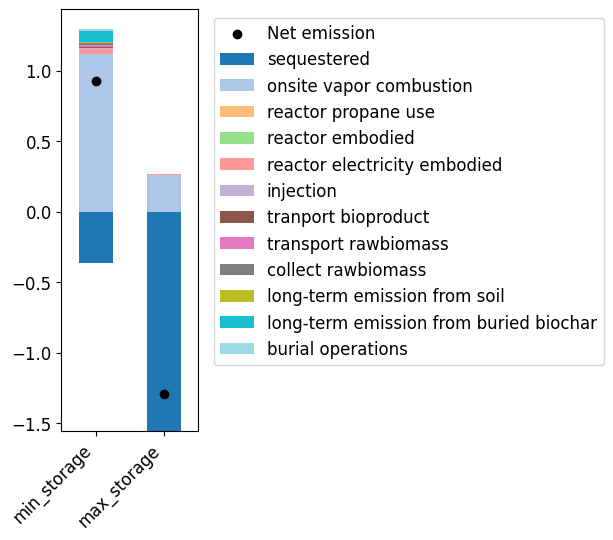

In [18]:
ax = df2.plot(x='scenario',kind='bar',stacked=True,cmap='tab20')

bar_totals = df2.drop(columns=['scenario']).sum(axis=1)
x_positions = range(len(df2))

# bar_totals_wo_counterfactual = df2.drop(columns=['scenario','feedstock counterfactual']).sum(axis=1)

plt.scatter(x_positions,bar_totals,color='black',zorder=5,label='Net emission')
# plt.scatter(x_positions,bar_totals_wo_counterfactual,facecolors='white',edgecolors='black',zorder=5,label='Net emission without counterfactual emission')

plt.legend(bbox_to_anchor=(1.05,1),loc='upper left',fontsize=12)
plt.xticks(rotation='horizontal',fontsize=12)
plt.xlabel('')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
# fname='minmax_bar.png'
# plt.savefig(fname)